#Import all necessary libraries

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.cluster import KMeans
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import average_precision_score, precision_recall_curve, plot_precision_recall_curve
from sklearn.utils import resample


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# EDA

Read the data into dataframe & EDA

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/Data02_PS_20174392719_1491204439457_log.csv')

df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


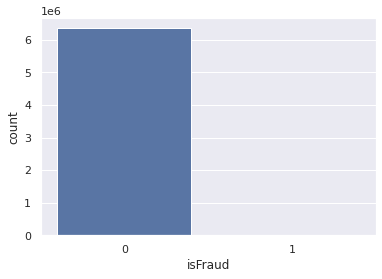

In [6]:
sns.set_theme(style="darkgrid")
sns.countplot(x="isFraud", data=df)

In [7]:
df.isFraud.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

# Data Preprocessing

In [8]:
df = df.drop(["nameOrig","nameDest","isFlaggedFraud"], axis=1)

In [9]:
df = df.loc[df['type'].isin(['TRANSFER','CASH_OUT'])]

In [10]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
2,1,TRANSFER,181.00,181.0,0.0,0.0,0.00,1
3,1,CASH_OUT,181.00,181.0,0.0,21182.0,0.00,1
15,1,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44,0
19,1,TRANSFER,215310.30,705.0,0.0,22425.0,0.00,0
24,1,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89,0


In [11]:
df.isFraud.value_counts()

0    2762196
1       8213
Name: isFraud, dtype: int64

In [12]:
# one-hot encoding
df = pd.get_dummies(df)
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_OUT,type_TRANSFER
2,1,181.00,181.0,0.0,0.0,0.00,1,0,1
3,1,181.00,181.0,0.0,21182.0,0.00,1,1,0
15,1,229133.94,15325.0,0.0,5083.0,51513.44,0,1,0
19,1,215310.30,705.0,0.0,22425.0,0.00,0,0,1
24,1,311685.89,10835.0,0.0,6267.0,2719172.89,0,0,1


In [13]:
# Split into X and y
y = df["isFraud"].values  # target attributes
X = df.drop(["isFraud"], axis=1) # input attributes


# Feature Engineering
# Inspired by https://www.kaggle.com/arjunjoshua/predicting-fraud-in-financial-payment-services
# Balance in fraud should be less

X['difBaOrig'] = X.newbalanceOrig + X.amount - X.oldbalanceOrg
X['diforBaDest'] = X.oldbalanceDest + X.amount - X.newbalanceDest


In [14]:
# Scale the independent variables
x_scale = preprocessing.MinMaxScaler().fit_transform(X.values)

#Standard ML training and evaluation 

In [15]:
# reduce the size of the data as it takes too long for training
reduce_x, large_x, reduce_y, large_y = train_test_split(x_scale, y,
                                                  test_size=0.9, stratify=y)
# data splitting
train_x, val_x, train_y, val_y = train_test_split(reduce_x, reduce_y,
                                                  test_size=0.4, stratify=reduce_y)


In [16]:
train_x.shape

(166224, 10)

In [17]:
val_x.shape

(110816, 10)

## Apply resampling technique

In [18]:
# resample the train data by rising the fraud sample
normal = train_x[train_y==0]
fraud = train_x[train_y==1]

print("Normal:",normal.shape)
print("Fraud:",fraud.shape)
print("Y shape:",train_y.shape)

Normal: (165731, 10)
Fraud: (493, 10)
Y shape: (166224,)


In [19]:
# Increase the number of fraud to 20% of the normal
upsample_fraud = resample(fraud,
                          replace=True,
                          n_samples=int(normal.shape[0]/5))
print("Fraud upsample:",upsample_fraud.shape)
# Join the fraud upsample with normal
resample_data = np.concatenate((normal, upsample_fraud), axis=0)
print("Combine:",resample_data.shape)

Fraud upsample: (33146, 10)
Combine: (198877, 10)


## Supervised ML techniques

### DT

In [20]:
# Decision Tree
DT_clf = DecisionTreeClassifier().fit(train_x, train_y)
# tree.plot_tree(DT_clf)

In [21]:
# DT Performance Evaluation
pred_y_DT = DT_clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y_DT))

print ("")
print ("Confusion Matrix: \n", confusion_matrix(val_y, pred_y_DT, labels=[1,0]))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y_DT))
precision = precision_score(val_y, pred_y_DT)
print ("Precision Score: ", precision)
recall = recall_score(val_y, pred_y_DT)
print ("Recall Score: ", recall)

print ("F1 Score: ", f1_score(val_y, pred_y_DT))
print ("ROC AUC: ", roc_auc_score(val_y, pred_y_DT))





Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110488
           1       0.97      0.98      0.97       328

    accuracy                           1.00    110816
   macro avg       0.98      0.99      0.99    110816
weighted avg       1.00      1.00      1.00    110816


Confusion Matrix: 
 [[   322      6]
 [    11 110477]]
Accuracy Score:  0.9998465925498123
Precision Score:  0.9669669669669669
Recall Score:  0.9817073170731707
F1 Score:  0.9742813918305597
ROC AUC:  0.9908038793750474


### LR

In [22]:
# Logistic regression
LR_clf = LogisticRegression().fit(train_x, train_y)


In [23]:
# LR Performance Evaluation
pred_y_LR = LR_clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y_LR))

print ("")
print ("Confusion Matrix: \n", confusion_matrix(val_y, pred_y_LR, labels=[1,0]))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y_LR))
precision = precision_score(val_y, pred_y_LR)
print ("Precision Score: ", precision)
recall = recall_score(val_y, pred_y_LR)
print ("Recall Score: ", recall)

print ("F1 Score: ", f1_score(val_y, pred_y_LR))
print ("ROC AUC: ", roc_auc_score(val_y, pred_y_LR))





Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110488
           1       1.00      0.01      0.02       328

    accuracy                           1.00    110816
   macro avg       1.00      0.51      0.51    110816
weighted avg       1.00      1.00      1.00    110816


Confusion Matrix: 
 [[     4    324]
 [     0 110488]]
Accuracy Score:  0.9970762344787756
Precision Score:  1.0
Recall Score:  0.012195121951219513
F1 Score:  0.024096385542168676
ROC AUC:  0.5060975609756098


### SVM

In [24]:
# Support Vector Machine
SVM_clf = svm.SVC().fit(train_x, train_y)


In [25]:
# SVM Performance Evaluation
pred_y_SVM = SVM_clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y_SVM))

print ("")
print ("Confusion Matrix: \n", confusion_matrix(val_y, pred_y_SVM, labels=[1,0]))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y_SVM))
precision = precision_score(val_y, pred_y_SVM)
print ("Precision Score: ", precision)
recall = recall_score(val_y, pred_y_SVM)
print ("Recall Score: ", recall)

print ("F1 Score: ", f1_score(val_y, pred_y_SVM))
print ("ROC AUC: ", roc_auc_score(val_y, pred_y_SVM))




Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110488
           1       1.00      0.06      0.11       328

    accuracy                           1.00    110816
   macro avg       1.00      0.53      0.56    110816
weighted avg       1.00      1.00      1.00    110816


Confusion Matrix: 
 [[    20    308]
 [     0 110488]]
Accuracy Score:  0.9972206179613052
Precision Score:  1.0
Recall Score:  0.06097560975609756
F1 Score:  0.11494252873563218
ROC AUC:  0.5304878048780488


### KNN

In [26]:
# K Nearest Neighbors
KNN_clf = KNeighborsClassifier(n_neighbors=3).fit(train_x, train_y)

In [27]:
# KNN Performance Evaluation
pred_y_KNN = KNN_clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y_KNN))

print ("")
print ("Confusion Matrix: \n", confusion_matrix(val_y, pred_y_KNN, labels=[1,0]))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y_KNN))
precision = precision_score(val_y, pred_y_KNN)
print ("Precision Score: ", precision)
recall = recall_score(val_y, pred_y_KNN)
print ("Recall Score: ", recall)

print ("F1 Score: ", f1_score(val_y, pred_y_KNN))
print ("ROC AUC: ", roc_auc_score(val_y, pred_y_KNN))




Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110488
           1       0.93      0.46      0.62       328

    accuracy                           1.00    110816
   macro avg       0.96      0.73      0.81    110816
weighted avg       1.00      1.00      1.00    110816


Confusion Matrix: 
 [[   151    177]
 [    12 110476]]
Accuracy Score:  0.9982944701126191
Precision Score:  0.9263803680981595
Recall Score:  0.4603658536585366
F1 Score:  0.615071283095723
ROC AUC:  0.7301286222894088


### RF

In [28]:
# Random Forrest
RF_clf = RandomForestClassifier().fit(train_x, train_y)

In [30]:
# RF Performance Evaluation
pred_y_RF = RF_clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y_RF))

print ("")
print ("Confusion Matrix: \n", confusion_matrix(val_y, pred_y_RF, labels=[1,0]))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y_RF))
precision = precision_score(val_y, pred_y_RF)
print ("Precision Score: ", precision)
recall = recall_score(val_y, pred_y_RF)
print ("Recall Score: ", recall)

print ("F1 Score: ", f1_score(val_y, pred_y_RF))
print ("ROC AUC: ", roc_auc_score(val_y, pred_y_RF))




Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110488
           1       0.99      0.99      0.99       328

    accuracy                           1.00    110816
   macro avg       0.99      1.00      0.99    110816
weighted avg       1.00      1.00      1.00    110816


Confusion Matrix: 
 [[   325      3]
 [     4 110484]]
Accuracy Score:  0.9999368322263933
Precision Score:  0.9878419452887538
Recall Score:  0.9908536585365854
F1 Score:  0.9893455098934552
ROC AUC:  0.9954087277550061


## Unsupervised ML techniques

### K means

In [31]:
## K means
Kmeans_clf = KMeans().fit(train_x)

In [32]:
# Predict the top 3% farthest points from center as anomaly
clusters_y_Kmeans = Kmeans_clf.predict(val_x)

clusters_centers=Kmeans_clf.cluster_centers_
dist = [np.linalg.norm(x-y) for x,y in zip(val_x,clusters_centers[clusters_y_Kmeans])]

pred_y_Kmeans=np.array(dist)
pred_y_Kmeans[dist>=np.percentile(dist,97)]=1
pred_y_Kmeans[dist<np.percentile(dist,97)]=0

# Kmeans Performance Evaluation

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y_Kmeans))

print ("")
print ("Confusion Matrix: \n", confusion_matrix(val_y, pred_y_Kmeans, labels=[1,0]))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y_Kmeans))
precision = precision_score(val_y, pred_y_Kmeans)
print ("Precision Score: ", precision)
recall = recall_score(val_y, pred_y_Kmeans)
print ("Recall Score: ", recall)

print ("F1 Score: ", f1_score(val_y, pred_y_Kmeans))
print ("ROC AUC: ", roc_auc_score(val_y, pred_y_Kmeans))




Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    110488
           1       0.03      0.26      0.05       328

    accuracy                           0.97    110816
   macro avg       0.51      0.61      0.52    110816
weighted avg       0.99      0.97      0.98    110816


Confusion Matrix: 
 [[    84    244]
 [  3241 107247]]
Accuracy Score:  0.9685514727115218
Precision Score:  0.02526315789473684
Recall Score:  0.25609756097560976
F1 Score:  0.04598959759102108
ROC AUC:  0.6133820293474095


### OCSVM

In [33]:
## One-Class SVM
OCSVM_clf = OneClassSVM(gamma='auto', nu=0.1).fit(train_x[train_y==0])

In [34]:
# convert from class -1 1 to 1 0
pred_y_OCSVM = OCSVM_clf.predict(val_x)
pred_y_OCSVM [pred_y_OCSVM ==1] = 0
pred_y_OCSVM [pred_y_OCSVM ==-1] = 1

# One-Class SVM Performance Evaluation

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y_OCSVM))

print ("")
print ("Confusion Matrix: \n", confusion_matrix(val_y, pred_y_OCSVM, labels=[1,0]))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y_OCSVM))
precision = precision_score(val_y, pred_y_OCSVM)
print ("Precision Score: ", precision)
recall = recall_score(val_y, pred_y_OCSVM)
print ("Recall Score: ", recall)

print ("F1 Score: ", f1_score(val_y, pred_y_OCSVM))
print ("ROC AUC: ", roc_auc_score(val_y, pred_y_OCSVM))




Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.90      0.95    110488
           1       0.02      0.51      0.03       328

    accuracy                           0.90    110816
   macro avg       0.51      0.71      0.49    110816
weighted avg       1.00      0.90      0.94    110816


Confusion Matrix: 
 [[  168   160]
 [11024 99464]]
Accuracy Score:  0.8990759457118106
Precision Score:  0.01501072194424589
Recall Score:  0.5121951219512195
F1 Score:  0.029166666666666664
ROC AUC:  0.7062097903579861


### Isolation Forest

In [35]:
## Isolation Forest
IsoF_clf = IsolationForest().fit(train_x[train_y==0])

In [36]:
# convert from class -1 1 to 1 0
pred_y_IsoF = IsoF_clf.predict(val_x)
pred_y_IsoF [pred_y_IsoF ==1] = 0
pred_y_IsoF [pred_y_IsoF ==-1] = 1

# Isolation Forest Performance Evaluation

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y_IsoF))

print ("")
print ("Confusion Matrix: \n", confusion_matrix(val_y, pred_y_IsoF, labels=[1,0]))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y_IsoF))
precision = precision_score(val_y, pred_y_IsoF)
print ("Precision Score: ", precision)
recall = recall_score(val_y, pred_y_IsoF)
print ("Recall Score: ", recall)

print ("F1 Score: ", f1_score(val_y, pred_y_IsoF))
print ("ROC AUC: ", roc_auc_score(val_y, pred_y_IsoF))




Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.90      0.95    110488
           1       0.02      0.70      0.04       328

    accuracy                           0.90    110816
   macro avg       0.51      0.80      0.49    110816
weighted avg       1.00      0.90      0.95    110816


Confusion Matrix: 
 [[  230    98]
 [10714 99774]]
Accuracy Score:  0.9024328616806238
Precision Score:  0.02101608187134503
Recall Score:  0.7012195121951219
F1 Score:  0.040809084457061745
ROC AUC:  0.8021248527596418


## Hybrid Model

### RF --> IsoF (supervised then unsupervised)

In [37]:
# those instance predicted as normal by rf will go through
# 2nd prediction by using IsoF

pred_y_RF_IsoF = IsoF_clf.predict(val_x[pred_y_RF==0])
pred_y_RF_IsoF [pred_y_RF_IsoF ==1] = 0
pred_y_RF_IsoF [pred_y_RF_IsoF ==-1] = 1


pred_y_RF[pred_y_RF==0] = pred_y_RF_IsoF


In [38]:
# RF_IsoF Performance Evaluation

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y_RF))

print ("")
print ("Confusion Matrix: \n", confusion_matrix(val_y, pred_y_RF, labels=[1,0]))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y_RF))
precision = precision_score(val_y, pred_y_RF)
print ("Precision Score: ", precision)
recall = recall_score(val_y, pred_y_RF)
print ("Recall Score: ", recall)

print ("F1 Score: ", f1_score(val_y, pred_y_RF))
print ("ROC AUC: ", roc_auc_score(val_y, pred_y_RF))



Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.90      0.95    110488
           1       0.03      0.99      0.06       328

    accuracy                           0.90    110816
   macro avg       0.51      0.95      0.50    110816
weighted avg       1.00      0.90      0.95    110816


Confusion Matrix: 
 [[  326     2]
 [10717 99771]]
Accuracy Score:  0.903272090672827
Precision Score:  0.02952096350629358
Recall Score:  0.9939024390243902
F1 Score:  0.05733884442881013
ROC AUC:  0.9484527400393111


### DT --> IsoF (supervised then unsupervised)

In [39]:
# those instance predicted as normal by DT will go through
# 2nd prediction by using IsoF

pred_y_DT_IsoF = IsoF_clf.predict(val_x[pred_y_DT==0])
pred_y_DT_IsoF [pred_y_DT_IsoF ==1] = 0
pred_y_DT_IsoF [pred_y_DT_IsoF ==-1] = 1


pred_y_DT[pred_y_DT==0] = pred_y_DT_IsoF

In [40]:
# DT_IsoF Performance Evaluation

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y_DT))

print ("")
print ("Confusion Matrix: \n", confusion_matrix(val_y, pred_y_DT, labels=[1,0]))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y_DT))
precision = precision_score(val_y, pred_y_DT)
print ("Precision Score: ", precision)
recall = recall_score(val_y, pred_y_DT)
print ("Recall Score: ", recall)

print ("F1 Score: ", f1_score(val_y, pred_y_DT))
print ("ROC AUC: ", roc_auc_score(val_y, pred_y_DT))


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.90      0.95    110488
           1       0.03      0.99      0.06       328

    accuracy                           0.90    110816
   macro avg       0.51      0.95      0.50    110816
weighted avg       1.00      0.90      0.95    110816


Confusion Matrix: 
 [[  324     4]
 [10720 99768]]
Accuracy Score:  0.9032269708345365
Precision Score:  0.02933719666787396
Recall Score:  0.9878048780487805
F1 Score:  0.05698206120295463
ROC AUC:  0.9453903834165414


### IsoF --> RF (unsupervised then supervised)

In [41]:
# those instance predicted as fraud by IsoF will go through
# 2nd prediction by using rf

pred_y_IsoF_RF = pred_y_IsoF.copy()

pred_y_IsoF_RF[pred_y_IsoF_RF==1] = RF_clf.predict(val_x[pred_y_IsoF_RF==1])


In [42]:
# IsoF_RF Performance Evaluation

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y_IsoF_RF))

print ("")
print ("Confusion Matrix: \n", confusion_matrix(val_y, pred_y_IsoF_RF, labels=[1,0]))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y_IsoF_RF))
precision = precision_score(val_y, pred_y_IsoF_RF)
print ("Precision Score: ", precision)
recall = recall_score(val_y, pred_y_IsoF_RF)
print ("Recall Score: ", recall)

print ("F1 Score: ", f1_score(val_y, pred_y_IsoF_RF))
print ("ROC AUC: ", roc_auc_score(val_y, pred_y_IsoF_RF))


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110488
           1       1.00      0.70      0.82       328

    accuracy                           1.00    110816
   macro avg       1.00      0.85      0.91    110816
weighted avg       1.00      1.00      1.00    110816


Confusion Matrix: 
 [[   229     99]
 [     1 110487]]
Accuracy Score:  0.9990976032341901
Precision Score:  0.9956521739130435
Recall Score:  0.698170731707317
F1 Score:  0.8207885304659499
ROC AUC:  0.8490808404753369


### IsoF --> DT (unsupervised then supervised)

In [43]:
# those instance predicted as fraud by IsoF will go through
# 2nd prediction by using DT

pred_y_IsoF_DT = pred_y_IsoF.copy()

pred_y_IsoF_DT[pred_y_IsoF_DT==1] = DT_clf.predict(val_x[pred_y_IsoF_DT==1])

In [44]:
# IsoF_DT Performance Evaluation

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y_IsoF_DT))

print ("")
print ("Confusion Matrix: \n", confusion_matrix(val_y, pred_y_IsoF_DT, labels=[1,0]))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y_IsoF_DT))
precision = precision_score(val_y, pred_y_IsoF_DT)
print ("Precision Score: ", precision)
recall = recall_score(val_y, pred_y_IsoF_DT)
print ("Recall Score: ", recall)

print ("F1 Score: ", f1_score(val_y, pred_y_IsoF_DT))
print ("ROC AUC: ", roc_auc_score(val_y, pred_y_IsoF_DT))


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110488
           1       0.98      0.70      0.81       328

    accuracy                           1.00    110816
   macro avg       0.99      0.85      0.91    110816
weighted avg       1.00      1.00      1.00    110816


Confusion Matrix: 
 [[   228    100]
 [     5 110483]]
Accuracy Score:  0.9990524833958995
Precision Score:  0.9785407725321889
Recall Score:  0.6951219512195121
F1 Score:  0.8128342245989304
ROC AUC:  0.8475383487181478


In [ ]:
from google.colab import drive
drive.mount('/content/drive')